In [1]:
import numpy as np
import scipy.optimize as op
import scipy.linalg as linalg
from scipy.special import gamma
from scipy.integrate import quad
import matplotlib.pyplot as plt
from getdist import plots, MCSamples, loadMCSamples, types
import emcee
import os
import time
from multiprocessing.pool import ThreadPool

### Default configurations

In [2]:
os.environ["OMP_NUM_THREADS"] = '1'
plt.rcParams['text.usetex'] = False
priorArray = np.array([[50., 100.], [0., 3.],[-3., 3.],[0.1, 2.]])
nsteps = 20000

### Loading data

In [3]:
#Loading the 32 H(z) data
z, Hz, errHz = np.genfromtxt('data/32CCdata.dat', comments='#', usecols=(0,1,2), unpack=True, delimiter=',')

#Loading data to estimate covariance matrix
zmod, imf, slib, sps, spsooo = np.genfromtxt('data/data_MM20.dat', comments='#', usecols=(0,1,2,3,4), unpack=True)

#Number of data
ndata = len(z)

### Analysis functions

In [12]:
#Function to identify which model will be used
def model(theta, freef, flat):
    if freef == True:
        if flat == False:
            h0, wm, wl, f = theta
            return [h0, wm, wl, f]
        elif flat == True:
            h0, wm, f = theta
            return [h0, wm, 1-wm, f]
        else:
            print("Invalid flatness...")
            return None
    elif freef == False:
        if flat == False:
            h0, wm, wl = theta
            return [h0, wm, wl, 1]
        elif flat == True:
            h0, wm = theta
            return [h0, wm, 1-wm, 1]
        else:
            print("Invalid flatness...")
            return None
    else:
        print("Invalid correction parameter...")
        return None

#Calculate chi2 for the model
def chi2Hz(par, inv_cov):
    E2 = par[1]*(1+z)**3+(1-par[1]-par[2])*(1+z)**2+par[2]

    if np.any(E2<0):
        return np.inf

    Hzm = par[0]*np.sqrt(E2)
    dhz = Hz-Hzm
    inv_covCorr = inv_cov/par[3]**2

    return np.dot(np.dot(dhz.T, inv_covCorr), dhz)

#Check if parameters are in prior interval
def lnpriorHz(par):
    for i in range(len(par)):
        if not priorArray[i][0] < par[i] < priorArray[i][1]:
            return -np.inf
    return 0.0

#Calculate the likelihood
def lnlikeHz(par, inv_cov):
    chi2 = chi2Hz(par, inv_cov)
    return -0.5*chi2 - ndata*np.log(par[3])

def lnprobHz(theta, freef, flat, inv_cov):
    par = model(theta, freef, flat)
    
    lp = lnpriorHz(par)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlikeHz(par, inv_cov)

#Minimize chi2
def find_bestfit(lnlike, par_ml, parnames, freef, flat, inv_cov):
    t1 = time.time()
    ndim = len(par_ml)
    chi2 = lambda par_ml, freef, flat, inv_cov: -2*lnlike(par_ml, freef, flat, inv_cov)
    result = op.minimize(chi2, par_ml, args=(freef, flat, inv_cov))
    if not result['success']:
        result = op.minimize(chi2, par_ml, args=(freef, flat, inv_cov), method='Nelder-Mead', options={'maxiter': 10000})
    par_ml = result['x']
    print('Maximum likelihood result:')
    for i in range(ndim):
        print(parnames[i],' = ',par_ml[i])
    print('chi2min =',result['fun'])
    t2 = time.time()
    print('Total time: {0:5.3f} seg'.format(t2-t1))
    return result

#Run MC
def run_emcee(par_ml, nwalkers, lnprob, freef, flat, ainput, nsteps, inv_cov):
    ndim = len(par_ml)
    pos = [par_ml +1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    
    with ThreadPool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[freef, flat, inv_cov], a=ainput, pool=pool)
        sampler.run_mcmc(pos, nsteps, progress=True)
    
    accept = sampler.acceptance_fraction
    print('Acceptance fraction:',accept)
    print('Minimum acceptance:',np.amin(accept))
    print('Maximum acceptance:',np.amax(accept))
    
    return sampler

#Remove burn in
def tira_burnin(sampler, burnin, ndim):
    samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
    return samples

def burninthin(sampler, tau):
    taumax = np.amax(tau)
    taumin = np.amin(tau)
    samples = sampler.get_chain(discard=int(2*taumax), thin=int(taumin/2), flat=True)
    print(samples.shape)
    return samples

#MC results
def MC_result(samples, par_ml, parnames):
    ndim = len(par_ml)
    par_mean = np.mean(samples,axis=0)
    par_median = np.percentile(samples, [50], axis=0)[0]
    par_valm = np.percentile(samples, [15.865], axis=0)[0]
    par_valp = np.percentile(samples, [84.135], axis=0)[0]
    par_sigm = par_mean - par_valm
    par_sigp = par_valp - par_mean
    print('MCMC result:')
    for i in range(ndim):
        print("""{0} = {1:5.5f} +{2:5.5f} -{3:5.5f} (median: {4:5.5f}, ml: {5:5.5f})"""\
              .format(parnames[i],par_mean[i],par_sigp[i],par_sigm[i],par_median[i],par_ml[i]))

#Insert a derived paramater
def insertDerived(sample, parnames, parlabel, num, gsample, derived, derivedName, derivedLabel):
    n = np.zeros(num)
    
    if derivedName not in parnames:
        newSample = np.c_[sample, derived]
        parnames.append(derivedName)
        gsample.addDerived(derived, name=derivedName, label=derivedLabel)
        
        return newSample, gsample, parnames, n

    elif derivedName in parnames:
        print('Parâmetro dependente já adicionado.')

        return sample, gsample, parnames, n

#Distribution funcion for chi2
def chiDist(chi, n):
    return (n**(n/2)*((chi)**((n-2)/2))*np.exp(-(n/2)*chi))/(2**(n/2)*gamma(n/2))

#Calculate cdf for chiDist
def chiCDF(x, n):
    res = np.zeros_like(x)
    for i, val in enumerate(x):
        y, err = quad(chiDist, 0, val, args=(n))
        res[i]=y
    return res

#Plot chi2 cdf
def plotChiDist(chimin, par, name=0):
    n = ndata - par
    chi = np.linspace(0, 2.5, 500)
    chiv = np.full((500), chimin/n)
    hv = chiDist(chi, n)
    cdf = chiCDF(chi, n)
    y = np.linspace(0, 1.8, 500)
    
    plt.plot(chi, hv, label="$h _{\\nu}$")
    plt.plot(chiv, y, '--', label="$\chi _{\\nu} ^{2}$" + "$= {0}$".format(np.round(chimin/n, 3)))
    plt.plot(chi, cdf, '--', label="cdf")
    
    plt.xticks(np.arange(0.0, 2.51, 0.5))
    plt.yticks(np.arange(0.0, 1.76, 0.25))
    plt.axis((0, 2.5, 0, 1.75))
    plt.grid(linestyle='-.', linewidth='0.5')
    plt.minorticks_on()
    
    plt.ylabel("$h_{\\nu}$")
    plt.xlabel("$\chi _{\\nu} ^{2}$")
    plt.legend(loc='best')
   
    if not name == 0:
        plt.savefig(name+'.pdf')
    
    plt.show()

## Computing the covariance matrix components

In [5]:
cov_mat_diag = np.zeros((len(z), len(z)), dtype='float64') 

for i in range(len(z)):
	cov_mat_diag[i,i] = errHz[i]**2

imf_intp = np.interp(z, zmod, imf)/100
slib_intp = np.interp(z, zmod, slib)/100
sps_intp = np.interp(z, zmod, sps)/100
spsooo_intp = np.interp(z, zmod, spsooo)/100

cov_mat_imf = np.zeros((len(z), len(z)), dtype='float64')
cov_mat_slib = np.zeros((len(z), len(z)), dtype='float64')
cov_mat_sps = np.zeros((len(z), len(z)), dtype='float64')
cov_mat_spsooo = np.zeros((len(z), len(z)), dtype='float64')

for i in range(len(z)):
	for j in range(len(z)):
		cov_mat_imf[i,j] = Hz[i] * imf_intp[i] * Hz[j] * imf_intp[j]
		cov_mat_slib[i,j] = Hz[i] * slib_intp[i] * Hz[j] * slib_intp[j]
		cov_mat_sps[i,j] = Hz[i] * sps_intp[i] * Hz[j] * sps_intp[j]
		cov_mat_spsooo[i,j] = Hz[i] * spsooo_intp[i] * Hz[j] * spsooo_intp[j]

### Computing different combinations of covariance matrix

In [6]:
#Suggested combination
cov_mat_sugg = cov_mat_spsooo+cov_mat_imf+cov_mat_diag
inv_mat_sugg = linalg.inv(cov_mat_sugg)

#Conservative combination
cov_mat_con = cov_mat_spsooo+cov_mat_imf+cov_mat_diag+cov_mat_slib
inv_mat_con = linalg.inv(cov_mat_con)

#Extra-conservative combination
cov_mat_eco = cov_mat_sps+cov_mat_imf+cov_mat_diag+cov_mat_slib
inv_mat_eco = linalg.inv(cov_mat_eco) 

# Flat LCDM with conservative combination

In [7]:
par_HzCon = [69.1929957609451,0.2480895086492853, 0.9]
ndimCon = len(par_HzCon)
prefixCon = 'LcdmHz32CovCon'
parlabelsCon = ["H_0","\Omega_m", "f"]
parlabtexCon = ["$H_0$","$\Omega_m$", "$f$"]
parnamesCon = ['H0','wm','f']

resultHzCon = find_bestfit(lnprobHz, par_HzCon, parnamesCon, freef=True, flat=True, inv_cov=inv_mat_con)
par_HzCon = resultHzCon['x']

Maximum likelihood result:
H0  =  63.25193066182145
wm  =  0.3356120758631086
f  =  0.6571993884321911
chi2min = 5.134862496451774
Total time: 0.081 seg


In [8]:
samplerHzCon = run_emcee(par_HzCon, 100, lnprobHz, True, True, 2.0, nsteps, inv_mat_con)

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [06:37<00:00, 50.30it/s]

Acceptance fraction: [0.6475  0.63905 0.6457  0.6422  0.645   0.63215 0.6421  0.636   0.6365
 0.6436  0.64485 0.64495 0.64375 0.64135 0.64285 0.64005 0.63785 0.63665
 0.64735 0.6459  0.6406  0.64705 0.63305 0.6316  0.6392  0.64585 0.6389
 0.64455 0.6374  0.6456  0.6363  0.64745 0.6444  0.63975 0.64435 0.6487
 0.6462  0.64585 0.6375  0.64575 0.6465  0.6422  0.64275 0.6394  0.6396
 0.64135 0.6488  0.6318  0.63615 0.64105 0.63575 0.64585 0.6439  0.63915
 0.64335 0.63745 0.6473  0.63885 0.6429  0.65045 0.64455 0.64505 0.643
 0.6399  0.6361  0.64775 0.641   0.6355  0.6413  0.63955 0.6406  0.6444
 0.64235 0.63735 0.63995 0.6374  0.6403  0.6357  0.63375 0.6403  0.6467
 0.6409  0.6424  0.6432  0.6392  0.6435  0.64585 0.64065 0.63745 0.6358
 0.64355 0.6396  0.63615 0.64165 0.6421  0.6386  0.64005 0.64095 0.639
 0.64635]
Minimum acceptance: 0.6316
Maximum acceptance: 0.65045


In [12]:
tauHzCon = samplerHzCon.get_autocorr_time()
print(tauHzCon)

tauHzmaxCon = np.amax(tauHzCon)
r = nsteps/tauHzmaxCon
print(r)

if(r>50):
    print('Convergiu! :)')
else:
    print('Não convergiu... :\'(:' )

[39.87769213 39.78445585 40.13390444]
498.33177906967734
Convergiu! :)


In [13]:
samplesHzCon = burninthin(samplerHzCon, 100)

(39600, 3)


In [14]:
MC_result(samplesHzCon, par_HzCon, parnamesCon)

MCMC result:
H0 = 62.67226 +5.16597 -5.22381 (median: 62.58929, ml: 63.25193)
wm = 0.34717 +0.05467 -0.05403 (median: 0.34212, ml: 0.33561)
f = 0.70965 +0.09140 -0.09407 (median: 0.70050, ml: 0.65720)


In [15]:
gsamplesHzCon = MCSamples(samples=samplesHzCon, names=parnamesCon, labels=parlabelsCon, ranges={'wm':(0, None)})
gsamplesHzCon.updateSettings({'countours': [0.682689492137, 0.954499736104, 0.997300203937]})

Removed no burn in


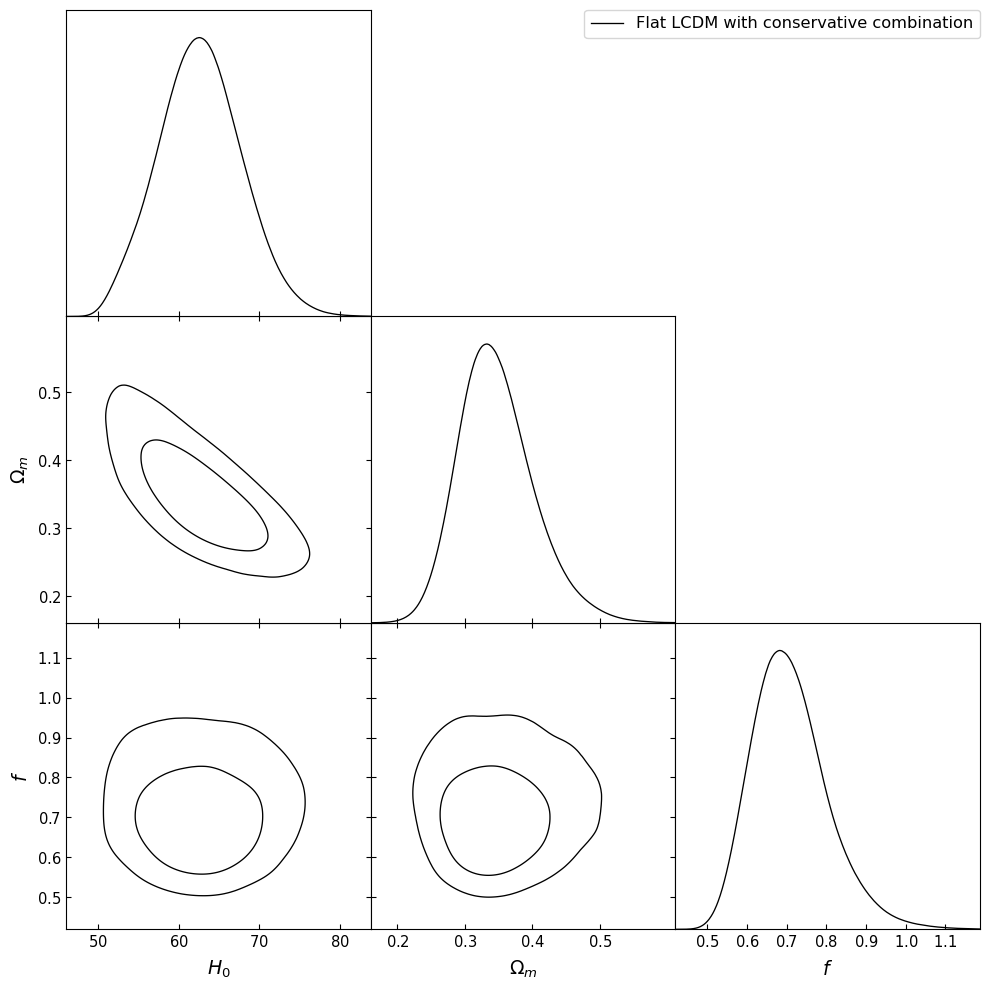

In [18]:
g = plots.getSubplotPlotter(width_inch=10)
g.triangle_plot([gsamplesHzCon], filled=False, legend_labels=['Flat LCDM with conservative combination'])
#g.export('fig/g'+prefixC+'All-triangle.pdf')

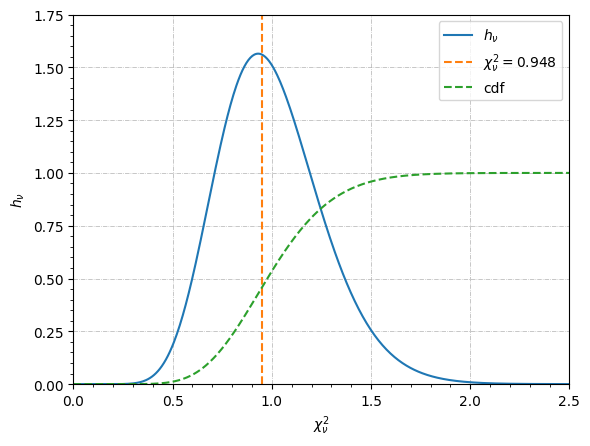

Probabilidade =  45.49157694006337
Chiv =  0.9480605813315194


In [16]:
chi2Con=chi2Hz(model([62.67226,0.34717, 0.70965], freef=True, flat=True), inv_mat_con)
plotChiDist(chi2Con, len(par_HzCon))
chivConperc, errCon = quad(chiDist, 0, chi2Con/(ndata-len(par_HzCon)), args=(ndata-len(par_HzCon)))
print('Probabilidade = ', chivConperc*100)
print('Chiv = ', chi2Con/(ndata-len(par_HzCon)))

# Flat LCDM with extra-conservative combination

In [18]:
par_HzEco = [69.1929957609451,0.2480895086492853, 0.9]
ndimEco = len(par_HzEco)
prefixEco = 'LcdmHz32CovEco'
parlabelsEco = ["H_0","\Omega_m", "f"]
parlabtexEco = ["$H_0$","$\Omega_m$", "$f$"]
parnamesEco = ['H0','wm','f']

resultHzEco = find_bestfit(lnprobHz, par_HzEco, parnamesEco, freef=True, flat=True, inv_cov=inv_mat_eco)
par_HzEco = resultHzEco['x']

Maximum likelihood result:
H0  =  59.082036309079626
wm  =  0.37715644606706034
f  =  0.6518026000938026
chi2min = 4.6072155568028705
Total time: 0.181 seg


In [19]:
samplerHzEco = run_emcee(par_HzEco, 100, lnprobHz, True, True, 2.0, nsteps, inv_mat_eco)

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [06:49<00:00, 48.88it/s]

Acceptance fraction: [0.62675 0.62625 0.62705 0.61845 0.6301  0.61585 0.6208  0.6196  0.62465
 0.63205 0.62305 0.62145 0.6306  0.62815 0.6253  0.62995 0.6276  0.62115
 0.6313  0.63015 0.62675 0.62955 0.6201  0.6257  0.62265 0.6229  0.61975
 0.62625 0.62275 0.6237  0.62335 0.626   0.6254  0.62065 0.6259  0.62885
 0.63165 0.62715 0.619   0.6206  0.6276  0.62765 0.6256  0.6254  0.6224
 0.6179  0.6263  0.6258  0.61695 0.6275  0.621   0.61935 0.62645 0.6286
 0.63095 0.623   0.6319  0.62415 0.6257  0.62985 0.62505 0.6251  0.62475
 0.6219  0.6173  0.63245 0.63135 0.6226  0.6234  0.62455 0.61405 0.62575
 0.6213  0.62565 0.6207  0.6188  0.6253  0.62395 0.6222  0.6213  0.6251
 0.62215 0.6238  0.62255 0.6221  0.6239  0.62955 0.6253  0.6187  0.62005
 0.6245  0.6222  0.62535 0.63175 0.6303  0.6237  0.6231  0.6235  0.61725
 0.62585]
Minimum acceptance: 0.61405
Maximum acceptance: 0.63245


In [22]:
tauHzEco = samplerHzEco.get_autocorr_time()
print(tauHzEco)

tauHzmaxEco = np.amax(tauHzEco)
r = nsteps/tauHzmaxEco
print(r)

if(r>50):
    print('Convergiu! :)')
else:
    print('Não convergiu... :\'(:' )

[44.07122748 43.39261568 41.47574367]
453.81082272241053
Convergiu! :)


In [23]:
samplesHzEco = burninthin(samplerHzEco, 100)

(39600, 3)


In [24]:
MC_result(samplesHzEco, par_HzEco, parnamesEco)

MCMC result:
H0 = 59.88807 +6.32781 -6.51868 (median: 59.18278, ml: 59.08204)
wm = 0.38044 +0.07479 -0.07456 (median: 0.37683, ml: 0.37716)
f = 0.69834 +0.09212 -0.09179 (median: 0.68771, ml: 0.65180)


In [25]:
gsamplesHzEco = MCSamples(samples=samplesHzEco, names=parnamesEco, labels=parlabelsEco, ranges={'wm':(0, None)})
gsamplesHzEco.updateSettings({'countours': [0.682689492137, 0.954499736104, 0.997300203937]})

Removed no burn in


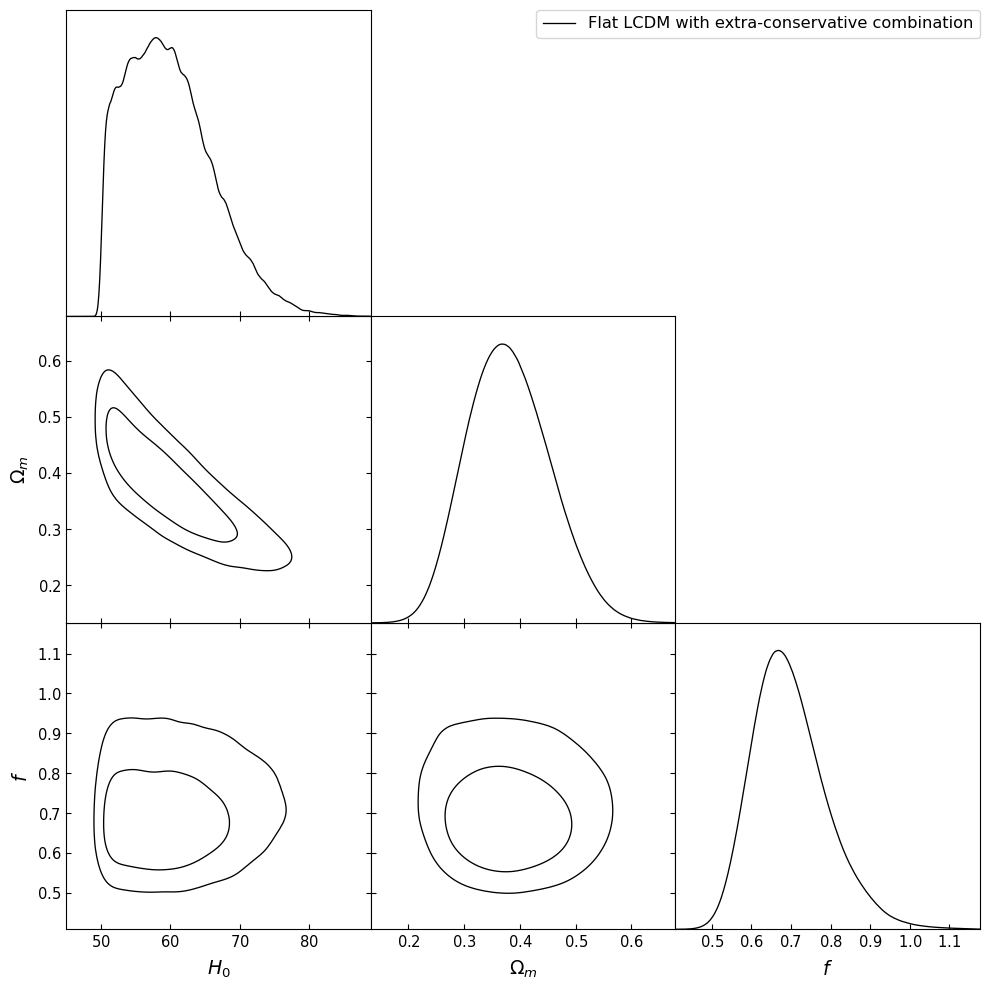

In [26]:
g = plots.getSubplotPlotter(width_inch=10)
g.triangle_plot([gsamplesHzEco], filled=False, legend_labels=['Flat LCDM with extra-conservative combination'])
#g.export('fig/g'+prefixC+'All-triangle.pdf')

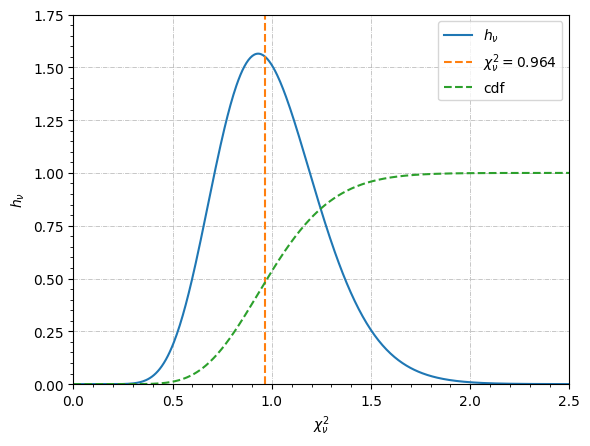

Probabilidade =  48.02235253939433
Chiv =  0.9643158692676693


In [19]:
chi2Eco=chi2Hz(model([59.88807,0.38044, 0.69834], freef=True, flat=True), inv_mat_eco)
plotChiDist(chi2Eco, len(par_HzEco))
chivEcoperc, errEco = quad(chiDist, 0, chi2Eco/(ndata-len(par_HzEco)), args=(ndata-len(par_HzEco)))
print('Probabilidade = ', chivEcoperc*100)
print('Chiv = ', chi2Eco/(ndata-len(par_HzEco)))